In [31]:
!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
import numpy
from sklearn.metrics import f1_score,precision_score,recall_score

##1) Installations and imports


a. Mount drive (if you are running on colab)

In [32]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

b. Clone or update competition repository
After cloning, under MyDrive, you will see NLI4CT-semeval-2023 folder with the training and dev set, aswell as the full list of CTRs.

In [33]:
%cd /content/drive/MyDrive

import os

PROJECT_DIR = '/content/drive/MyDrive/semeval-2024'
PROJECT_GITHUB_URL = 'https://github.com/ai-systems/Task-2-SemEval-2024.git'

if not os.path.isdir(PROJECT_DIR):
  !git clone {PROJECT_GITHUB_URL}
else:
  %cd {PROJECT_DIR}
  !git pull {PROJECT_GITHUB_URL}

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive'
C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024


fatal: destination path 'Task-2-SemEval-2024' already exists and is not an empty directory.


##2) Dataset

In [34]:
# Training data
#!unzip /content/drive/MyDrive/Task-2-SemEval-2024/training_data.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [35]:
# Dev set
import json

dev_path = r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\dev.json"
with open(dev_path) as json_file:
    dev = json.load(json_file)

# Example instance
print(dev[list(dev.keys())[1]])

{'Type': 'Comparison', 'Section_id': 'Eligibility', 'Primary_id': 'NCT00425854', 'Secondary_id': 'NCT01224678', 'Statement': 'Patients with significantly elevated ejection fraction are excluded from the primary trial, but can still be eligible for the secondary trial if they are 55 years of age or over', 'Label': 'Contradiction'}


In [36]:
uuid_list = list(dev.keys())
statements = []
gold_dev_primary_evidence = []
gold_dev_secondary_evidence = []
for i in range(len(uuid_list)):
  #Retrieve all statements from the development set
  statements.append(dev[uuid_list[i]]["Statement"])

##3) TF-IDF Entailment prediction baseline

In [37]:
Results = {}

for i in range(len(uuid_list)):
  primary_ctr_path = os.path.join(r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\CT json",dev[uuid_list[i]]["Primary_id"]+".json")
  with open(primary_ctr_path) as json_file:
    primary_ctr = json.load(json_file)

  #Retrieve the full section from the primary trial
  primary_section = primary_ctr[dev[uuid_list[i]]["Section_id"]]

  #Convert a primary section entries to a matrix of TF-IDF features.
  vectorizer = TfidfVectorizer().fit(primary_section)
  X_s = vectorizer.transform([statements[i]])
  X_p = vectorizer.transform(primary_section)
  #Compute the cosine similarity between the primary section entries and the statement
  primary_scores = cosine_distances(X_s, X_p)
  #Repeat for the secondary trial
  if dev[uuid_list[i]]["Type"] == "Comparison":
    secondary_ctr_path = os.path.join(r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\CT json",dev[uuid_list[i]]["Secondary_id"]+".json")
    with open(secondary_ctr_path) as json_file:
      secondary_ctr = json.load(json_file)
    secondary_section = secondary_ctr[dev[uuid_list[i]]["Section_id"]]
    vectorizer = TfidfVectorizer().fit(secondary_section)
    X_s = vectorizer.transform([statements[i]])
    X_p = vectorizer.transform(secondary_section)
    secondary_scores = cosine_distances(X_s, X_p)
    #Combine and average the cosine distances of all entries from the relevant section of the primary and secondary trial
    combined_scores = []
    combined_scores.extend(secondary_scores[0])
    combined_scores.extend(primary_scores[0])
    score = numpy.average(combined_scores)
    #If the cosine distance is gless than 0.9 the prediction is entailment
    if score > 0.9:
      Prediction = "Contradiction"
    else:
      Prediction = "Entailment"
    Results[str(uuid_list[i])] = {"Prediction":Prediction}
  else:
    #If the cosine distance is greater than 0.9 the prediction is contradiction
    score = numpy.average(primary_scores)
    if score > 0.9:
      Prediction = "Contradiction"
    else:
      Prediction = "Entailment"
    Results[str(uuid_list[i])] = {"Prediction":Prediction}


## Save the results in the submission format.

In [38]:
print(Results)
with open(r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\results.json",'w') as jsonFile:
    jsonFile.write(json.dumps(Results,indent=4))

{'1adc970c-d433-44d0-aa09-d3834986f7a2': {'Prediction': 'Contradiction'}, '6b9162d0-0816-46d4-81af-c60028dcc63b': {'Prediction': 'Entailment'}, '0b6cc8e3-69ee-4a91-b93d-2ad3fddce65f': {'Prediction': 'Contradiction'}, 'cc1f712a-2116-4e40-9810-f315e3fa5ff8': {'Prediction': 'Entailment'}, '904061c0-14fa-4f13-9118-9a41e24fa8eb': {'Prediction': 'Entailment'}, '43ee7645-ce1e-42d5-9a74-3e379f6f367b': {'Prediction': 'Contradiction'}, '0cef8c8e-7986-46c7-a597-c5733a9899c0': {'Prediction': 'Contradiction'}, '43ce26e5-03fa-4e9d-b0eb-6ea356295753': {'Prediction': 'Contradiction'}, '3facad41-0221-42f8-834d-470e65c4aad5': {'Prediction': 'Entailment'}, '9cbc00e9-3a2d-4471-a93e-72c95132fb6a': {'Prediction': 'Entailment'}, '8b91cab9-d858-45f3-bf8d-3d6fc55b4818': {'Prediction': 'Entailment'}, '4a75574c-fa86-4e62-a210-81c7b98a3807': {'Prediction': 'Contradiction'}, 'd0b50aeb-aad8-4a8d-aae6-5c58a7d382c7': {'Prediction': 'Entailment'}, 'b0b61978-57db-4a1c-812c-509e8b05f2dc': {'Prediction': 'Contradiction'}

##4) Evaluation

Compute F1 score, Precision, and Recall. Note that in the final evaluation systems will be ranked by Faithfulness and Consistency, which cannot be computed on the training and development set.

In [39]:
def main():

    gold = dev
    results = Results
    uuid_list = list(results.keys())

    results_pred = []
    gold_labels = []
    for i in range(len(uuid_list)):
        if results[uuid_list[i]]["Prediction"] == "Entailment":
            results_pred.append(1)
        else:
            results_pred.append(0)
        if gold[uuid_list[i]]["Label"] == "Entailment":
            gold_labels.append(1)
        else:
            gold_labels.append(0)

    f_score = f1_score(gold_labels,results_pred)
    p_score = precision_score(gold_labels,results_pred)
    r_score = recall_score(gold_labels,results_pred)

    print('F1:{:f}'.format(f_score))
    print('precision_score:{:f}'.format(p_score))
    print('recall_score:{:f}'.format(r_score))

if '__main__' == __name__:
    main()

F1:0.502415
precision_score:0.485981
recall_score:0.520000


## Our approach

The submitted systems for this task use various techniques and models, including:

1. Generative LLMs: 8 submissions
2. Discriminative LLMs: 16 submissions
3. Ontology-based: 1 submission
4. Semantic rule-based: 1 submission
5. Biomedical Pre-training: 12 submissions

Discriminative transformers, especially those fine-tuned for specific tasks, have shown strong performance in various natural language processing (NLP) tasks. I addition to this, pre-training on large biomedical datasets can help models capture domain-specific features, which is crucial when dealing with clinical trial reports. 


There are 2 main tasks involved in this:

**A. Choose a Discriminative Transformer Model:** Select a pre-trained transformer model suitable for your task. Models like BERT, RoBERTa, or BioBERT are good choices. We can leverage models from the Hugging Face Model Hub.

**B. Biomedical Pre-training:** Fine-tune our chosen discriminative transformer on a large biomedical dataset. We can use publicly available biomedical corpora or create your own dataset by scraping relevant biomedical texts.

**C. Hybrid Model Architecture:** Build a hybrid model architecture that combines the discriminative transformer with the biomedical pre-trained features. You may append additional layers to the pre-trained model to adapt it to your specific task.

In [40]:
# Install necessary libraries
#!pip install transformers scikit-learn
!pip install torch torchvision torchaudio

import os
import json
import numpy as np
import torch
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import BertTokenizer, BertForSequenceClassification


In [41]:
# Load the training set
train_path = r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\train.json"
with open(train_path) as json_file:
    train_data = json.load(json_file)

# Load the development set
dev_path = r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\dev.json"
with open(dev_path) as json_file1:
    dev_data = json.load(json_file1)

In [72]:
train_data

{'5bc844fc-e852-4270-bfaf-36ea9eface3d': {'Type': 'Comparison',
  'Section_id': 'Intervention',
  'Primary_id': 'NCT01928186',
  'Secondary_id': 'NCT00684983',
  'Statement': 'All the primary trial participants do not receive any oral capecitabine, oral lapatinib ditosylate or cixutumumab IV, in conrast all the secondary trial subjects receive these.',
  'Label': 'Contradiction'},
 '86b7cb3d-6186-4a04-9aa6-b174ab764eed': {'Type': 'Single',
  'Section_id': 'Eligibility',
  'Primary_id': 'NCT00662129',
  'Statement': 'Patients with Platelet count over 100,000/mm¬¨‚â•, ANC <  1,700/mm¬¨‚â• and Hemoglobin between 4 to 5 grams per deciliter are eligible for the primary trial.',
  'Label': 'Contradiction'},
 'dbed5471-c2fc-45b5-b26f-430c9fa37a37': {'Type': 'Comparison',
  'Section_id': 'Adverse Events',
  'Primary_id': 'NCT00093145',
  'Secondary_id': 'NCT00703326',
  'Statement': 'Heart-related adverse events were recorded in both the primary trial and the secondary trial.',
  'Label': 'Ent

In [78]:
dev_data

{'1adc970c-d433-44d0-aa09-d3834986f7a2': {'Type': 'Single',
  'Section_id': 'Results',
  'Primary_id': 'NCT00066573',
  'Statement': 'there is a 13.2% difference between the results from the two the primary trial cohorts',
  'Label': 'Contradiction'},
 '6b9162d0-0816-46d4-81af-c60028dcc63b': {'Type': 'Comparison',
  'Section_id': 'Eligibility',
  'Primary_id': 'NCT00425854',
  'Secondary_id': 'NCT01224678',
  'Statement': 'Patients with significantly elevated ejection fraction are excluded from the primary trial, but can still be eligible for the secondary trial if they are 55 years of age or over',
  'Label': 'Contradiction'},
 '0b6cc8e3-69ee-4a91-b93d-2ad3fddce65f': {'Type': 'Comparison',
  'Section_id': 'Adverse Events',
  'Primary_id': 'NCT02273973',
  'Secondary_id': 'NCT00281697',
  'Statement': 'a significant number of the participants in the secondary trial and the primary trial suffered from Enterocolitis',
  'Label': 'Contradiction'},
 'cc1f712a-2116-4e40-9810-f315e3fa5ff8': 

In [92]:
from transformers import BertTokenizer, BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming 2 classes (binary classification)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [95]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

class CustomDataset(Dataset):
    def __init__(self, instances, tokenizer, max_length=128):
        self.instances = instances
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        instance = self.instances[idx]
        statement = instance["Statement"]
        label = 1 if instance["Label"] == "Entailment" else 0

        # Tokenize and encode text
        encoding = self.tokenizer(
            statement,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}

# Assuming you have loaded train_data and dev_data
train_instances = [{"Statement": data["Statement"], "Label": data["Label"]} for data in train_data.values()]
dev_instances = [{"Statement": data["Statement"], "Label": data["Label"]} for data in dev_data.values()]

# Replace 'bert-base-uncased' with your actual model name
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Replace max_length with the correct value
max_length = 512

train_dataset = CustomDataset(train_instances, tokenizer, max_length=max_length)
dev_dataset = CustomDataset(dev_instances, tokenizer, max_length=max_length)

In [96]:
from torch.utils.data import DataLoader
from transformers import AdamW

# Create DataLoader for training and dev sets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False)

# Set up training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

In [97]:
from transformers import AutoTokenizer, AutoModel

# Replace 'bert-base-uncased' with the actual model name you are using
model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

max_length = model.config.max_position_embeddings
print(f"Maximum length supported by the model: {max_length}")


Maximum length supported by the model: 512


In [107]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


AttributeError: 'NoneType' object has no attribute 'backward'

In [101]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

class CustomDataset(Dataset):
    def __init__(self, instances, tokenizer, max_length=128):
        self.instances = instances
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        instance = self.instances[idx]
        statement = instance["Statement"]
        label = 1 if instance["Label"] == "Entailment" else 0

        # Tokenize and encode text
        encoding = self.tokenizer(
            statement,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}



In [108]:
# Assuming you have loaded train_data and dev_data
train_instances = [{"Statement": data["Statement"], "Label": data["Label"]} for data in train_data.values()]
dev_instances = [{"Statement": data["Statement"], "Label": data["Label"]} for data in dev_data.values()]

# Replace 'bert-base-uncased' with your actual model name
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Replace max_length with the correct value
max_length = 512

train_dataset = CustomDataset(train_instances, tokenizer, max_length=max_length)
dev_dataset = CustomDataset(dev_instances, tokenizer, max_length=max_length)

# Create DataLoader for training and dev sets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=8, shuffle=False)

# Replace 'bert-base-uncased' with your actual model name
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming 2 classes (binary classification)

# Set up training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
'''   optimizer.zero_grad()
        loss.backward()
        optimizer.step()
'''

In [110]:
# Evaluation loop (similar to training loop, but without backward pass)
model.eval()
for batch in dev_dataloader:
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["label"]

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Add your evaluation logic here
    # For example, you can compute accuracy or other metrics
    predictions = torch.argmax(outputs.logits, dim=1)
    accuracy = (predictions == labels).float().mean()

    print(f"Validation Accuracy: {accuracy.item()}")

Validation Accuracy: 0.5
Validation Accuracy: 0.75
Validation Accuracy: 0.5
Validation Accuracy: 0.25
Validation Accuracy: 0.5
Validation Accuracy: 0.75
Validation Accuracy: 0.625
Validation Accuracy: 0.625
Validation Accuracy: 0.75
Validation Accuracy: 0.25
Validation Accuracy: 0.5
Validation Accuracy: 0.625
Validation Accuracy: 0.875
Validation Accuracy: 0.375
Validation Accuracy: 0.375
Validation Accuracy: 0.75
Validation Accuracy: 0.5
Validation Accuracy: 0.625
Validation Accuracy: 0.625
Validation Accuracy: 0.375
Validation Accuracy: 0.375
Validation Accuracy: 0.625
Validation Accuracy: 0.375
Validation Accuracy: 0.5
Validation Accuracy: 0.5


--------------------------------------------------------------------------------------------------------------------------------

In [111]:
# Evaluation on dev set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in dev_dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1).tolist()

        all_predictions.extend(predictions)
        all_labels.extend(labels.tolist())


KeyboardInterrupt: 

In [112]:
# Calculate evaluation metrics
f_score = f1_score(all_labels, all_predictions)
p_score = precision_score(all_labels, all_predictions)
r_score = recall_score(all_labels, all_predictions)

print('F1: {:.6f}'.format(f_score))
print('Precision: {:.6f}'.format(p_score))
print('Recall: {:.6f}'.format(r_score))

F1: 0.666667
Precision: 0.528302
Recall: 0.903226


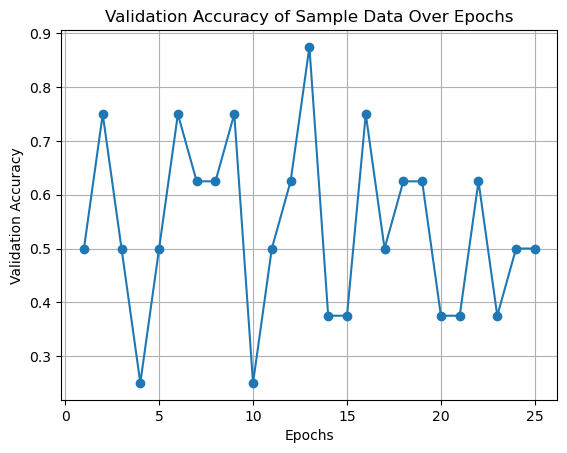

In [114]:
import matplotlib.pyplot as plt

# Validation accuracy values (replace with your actual values)
validation_accuracies = [0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.625, 0.625, 0.75, 0.25, 0.5, 0.625, 0.875, 0.375, 0.375, 0.75, 0.5, 0.625, 0.625, 0.375, 0.375, 0.625, 0.375, 0.5, 0.5]

# Epochs (replace with your actual epoch values)
epochs = list(range(1, len(validation_accuracies) + 1))

# Plotting the validation accuracy
plt.plot(epochs, validation_accuracies, marker='o')
plt.title('Validation Accuracy of Sample Data Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the trained model
model_name = 'bert-base-uncased'  # Replace with the actual model name
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Assuming 2 classes (binary classification)

In [ ]:
# Load the test data
test_path = r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\practice_test.json" 
with open(test_path) as json_file:
    test_data = json.load(json_file)

# Tokenize and create instances for the test data
test_instances = [{"Statement": data["Statement"]} for data in test_data.values()]

# Tokenize and encode the test data
test_encodings = tokenizer([instance["Statement"] for instance in test_instances], truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")

# Create DataLoader for the test set
test_dataset = CustomDataset(test_instances, tokenizer, max_length=max_length)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Load test data
test_path = r"C:\Users\Srija Vakiti\Desktop\Task-2-SemEval-2024\test.json"
with open(test_path) as json_file:
    test_data = json.load(json_file)

# Create test instances
test_instances = [{"Statement": data["Statement"]} for data in test_data.values()]



In [ ]:
class CustomDataset(Dataset):
    def __init__(self, instances, tokenizer, max_length=128):
        self.instances = instances
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        instance = self.instances[idx]
        statement = instance["Statement"]

        # Check if "Label" key is present
        if "Label" in instance:
            label = 1 if instance["Label"] == "Entailment" else 0
        else:
            # Set a default label if "Label" key is not present
            label = 0

        # Tokenize and encode text
        encoding = self.tokenizer(
            statement,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {"input_ids": input_ids, "attention_mask": attention_mask, "label": label}

# Create a CustomDataset for the test data
test_dataset = CustomDataset(test_instances, tokenizer, max_length=max_length)

# Create DataLoader for the test set
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
# Evaluate on the test set
model.eval()
all_test_predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1).tolist()

        all_test_predictions.extend(predictions)

# Save predictions to a file (e.g., results.json)
results = {"predictions": all_test_predictions}
with open("fresults.json", "w") as results_file:
    json.dump(results, results_file)
